In [1]:
!pip install shap

In [2]:
import shap
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from matplotlib.pyplot import cm
import matplotlib.colors as colors
import cycler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split



# set plotting parameters from the beginning
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 14}
axes = {
        'titlesize' : 20,
        'labelsize' : 18}
figure = {'figsize':(16,6),
         'autolayout':True}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **axes)
matplotlib.rc('figure', **figure)

# Code for [Opening the Black Box](https://docs.google.com/document/d/1h0weBm2xI2cpbg0x9JsWoK5rOkc4KlZoFuhsm4jiGJQ/edit)

* This notebook includes all of the calculations used in the post.
* I also include some additional material.
* Some of the functions are taken from the [code repo](https://github.com/dvaughan79/data-science-hard-parts-code/blob/main/ch13_stortellingML.ipynb) for Chapter 13 of [Data Science: The Hard Parts](https://www.amazon.com/s?k=data+science+the+hard+parts&crid=3CZSC6B5D82HP&sprefix=The+hard+parts%2Caps%2C692&ref=nb_sb_ss_ts-doa-p_6_14)

## Let's start with an example to motivate this discussion

A data scientist wants to predict the time it takes for objects of different masses that are dropped from different heights and different locations.  She has a rich dataset for many experiments done across the globe. After careful consideration she decides to use the following features to predict time:
* Height ($h$)
* Initial velocity ($v$)
* Mass ($m$)
* Distance to the equator ($d$)

Her mental model is thus:

$$
t = f(h, v, m, d)
$$

True DGP:
$$
h_t = h_0 + v*t + 0.5gt^2
$$

$$
t = \frac{-v \pm \sqrt{v^2 + 2g(h_t - h_0)}}{g}
$$

In [3]:
def simulate_height(seed, nobs, const_velocity = False):
  np.random.seed(seed)  # fix a random seed for replication
  noise = np.sqrt(0.1)*np.random.randn(nobs)  # normally distributed noise N(0,0.1)
  v = np.floor(np.sqrt(10)*np.abs(np.random.randn(nobs))) # velocities have to be positive
  if const_velocity:
    v = 5
  t = 5 + np.sqrt(5)*np.random.randn(nobs)
  t2 = t**2
  a = 9.8  # in Earth acceleration due to gravity is always 9.8 m/s^2
  m = np.random.randint(2,20,nobs)
  d = np.random.randint(10,1000,nobs)
  # from physics 101 we know that: h_t = h_0 + v_0*t + 0.5*g*t^2
  h = v*t + 0.5*a*t**2 + noise
  # get everything into a dataframe
  df = pd.DataFrame({
      'height': h,
      'velocity': v,
      'mass' : m,
      'dist_to_equat' : d,
      'time' : t,
      'time2' : t2

  })
  return df


In [4]:
# let's test this function
seed = 1098
df = simulate_height(seed, nobs = 100, const_velocity = True)
feats_test = ['time','time2']
xmat_test = df[feats_test]
ymat_test = df[['height']]
# test with a linear regression: h = g(t,m,d)
mod = LinearRegression()
mod.fit(xmat_test, ymat_test)
print("{:<20} {:<15} {:<10} {:<10}".format('Coefficients:', 'Intercept', 'linear t', 'quad t'))
print("{:<20} {:<15} {:<10} {:<10}".format('True:', '0', '5', str(0.5*9.8)))
print("{:<20} {:<15} {:<10} {:<10}".format('Estimated:', str(round(mod.intercept_[0],2)), str(round(mod.coef_[0][0],2)), str(round(mod.coef_[0][1],2))))

Coefficients:        Intercept       linear t   quad t    
True:                0               5          4.9       
Estimated:           -0.03           5.03       4.9       


#### Now simulate a model, train it with a GBR and fix everything but time

In [5]:
def compute_pdp2(xdf, var_name, model, drop_outliers = True, pmin = 0.05, pmax = 0.95, is_regression=True):
    """
    Check THP repo
    """
    # calculate grid
    ncols = len(xdf.columns)
    if drop_outliers:
        xmin, xmax = xdf[var_name].quantile([pmin, pmax])
    else:
        xmin, xmax = xdf[var_name].min(), xdf[var_name].max()
    grid_size = 10
    grid = np.linspace(xmin, xmax, grid_size)
    # loop over grid and predict
    col_lab = f'pdp_{var_name}'
    pdp = pd.DataFrame(index=grid, columns = [col_lab])
    ice_df = pd.DataFrame(index=xdf.index, columns = grid)
    for g, grd in enumerate(grid):
        xdfg = xdf.copy()
        xdfg[var_name] = grd
        if is_regression:
          yhat = model.predict(xdfg)
        else:
          yhat = model.predict_proba(xdfg)[:,1]

        ice_df[grd] = yhat
        pdp_g = np.mean(yhat) # average of the predictions
        pdp[col_lab].loc[grd] = pdp_g
    return pdp, ice_df

In [6]:
seed = 2381
nobs = 1000
df = simulate_height(seed, nobs, const_velocity = False)
df.head()

,height,velocity,mass,dist_to_equat,time,time2
0,71.036263,5.0,10,560,3.331178,11.096745
1,355.307703,2.0,8,454,8.312818,69.102941
2,57.744527,2.0,12,454,3.232441,10.448676
3,42.257399,0.0,16,287,2.936700,8.624208
4,215.846788,3.0,5,55,6.340116,40.197068


In [7]:
# I don't need to split between train/valid here (but you should in applications!)
feats = ['time', 'velocity', 'velocity','dist_to_equat']
y_df = df['height']
X_train = df[feats]

In [8]:
# I'm using default metaparameters with no optimization.  But you should in applications!
state = 1020
reg = GradientBoostingRegressor(random_state=state).fit(X_train, y_df)

In [9]:
pdp, _ = compute_pdp2(xdf=X_train, var_name='time', model=reg)

Text(0, 0.5, 'Height (m)')

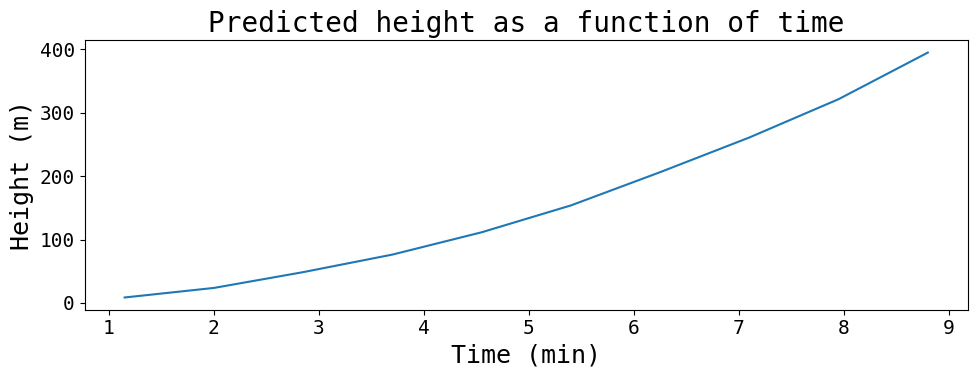

In [10]:
fig, ax = plt.subplots(figsize=(10,4))
pdp.plot(ax=ax)
ax.get_legend().remove()
ax.set_title('Predicted height as a function of time')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Height (m)')

# Simulated example: small and medium business loans


#### Storytelling

As discussed in [Data Science: The Hard Parts](https://www.amazon.com/s?k=data+science+the+hard+parts&crid=3CZSC6B5D82HP&sprefix=The+hard+parts%2Caps%2C692&ref=nb_sb_ss_ts-doa-p_6_14) it's always good to start with some storytelling to come up with hypothesis. For instance, why would someone pay me back or not?  The simplest and broadest answer is that companies pay back because they _want_ and because they _can_. (I also use this rationale quite a bit in [Analytical Skills for AI and DS](https://www.amazon.com/s?k=analytical+skills+for+ai+and+data+science&crid=16GSAG4NRZV0C&sprefix=analytical+skil%2Caps%2C163&ref=nb_sb_ss_ts-doa-p_2_15))

* **Fraud**: Some individuals are fraudsters, so by definition, they don't _want_ to pay you back.  We need to model fraudsters.  SMBs usually don't have access to credit, so even if credit bureau data were available, fraudsters are usually  sophisticated enough that they change their identity.  But fraudsters are also impatient: they look for short-term gains, so `tenure` is a proxy.  Fraudsters are more likely to be new customers for us (if you had already defraud us, most likely we have already blocked you, so you're tenure doesn't advance)
* **Pissed customers**: some customers may feel that they were treated unfairly, and decide to reciprocate by not paying back.  When they applied for the loan they wanted to pay back, but after some incident they changed their mind  If this hypothesis is right, a feature like `contacts to customer support with negative sentiment`, might proxy this.  The hypothesis is that pissed off customers are less likely to repay.
* **Financial conditions changed**: many SMBs take a loan because at the time of the loan application they foresaw a positive economic outlook. Conditions may have changed, however.  This is a harder feature to model: if you use something like the short- or medium- term change in revenue at the time of the application ($\Delta r_{t,k} = r_t - r_{t-k}$) you will capture good and bad merchants since you may have past and future positive growth, or past positive growth with future negative growth.  Many lenders actually predict the income or revenues, so if you have enough data to make a solid prediction, you can use that as a feature.  Alternatively you can come up with another hypothesis.  For instance, merchants with highly variable growth rates in revenue (sometimes it's positive, sometimes negative).  If this hypothesis is true, you can both $\Delta r_{t,k}$ and interact its standard deviation $STD(\Delta r_{t,k})$.
* **Loan conditions**: many practitioners believe that customers are inherently good or bad, and good customers may turn into bad ones because their financial conditions changed.  While this is true, it's also true that the loan conditions (interest rate, term and size) interact with your financial conditions.  If interest rates are not fixed, and all of a sudden they increase, customers may not be able to pay even if their income hasn't changed (eg. [here](https://finance.yahoo.com/news/default-cycle-started-amid-feds-032028752.html?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAANzT4wCwRcJe77WjWKSIaS3eDKy64a-xVDDTRGl2bU0P1DrWjPYapClcVdKeLlXs_QB0bRESI6eUIgEt6tYu27ixvA5UTfrka_eSKOTi7vGvNHyLsJHoWdGNORfNEMIm2e4fJn-6VtIP0Mjo-NEThyVhOzE3WLCrz-18v_TJhFfs)).  A related problem has to do with [confounding bias](https://decisionmatrix.substack.com/p/what-is-confounding-or-selection), also known as _adverse selection_: merchants that apply for loans with high interest rates are also more likely to default if the reason behind their acceptance of such unfavorable loan is because they are currently under a highly stressful financial situation ("that loan might actually save us from bankruptcy (or not)").
* **SMBs fail quickly**: survival rates for new SMBs are extremely low, so newer merchants may default just because their business fails.  A fintech may or may not know the lifespan of an SMB.  If you have it, just include it, otherwise, approximate it with the `tenure` at your company.  Unfortunately this is not a great proxy: it may also be that an SMB has been a while operating, but just switched to your company as a customer.

## Let's simulate a latent variable model for the default probability (see ch. 9 of The Hard Parts)

I want to use these simulated features:

1. Tenure: (-)
2. Number of contacts to customer support per month (+)
3. Change in revenues before providing getting the loan (-)
4. Interest rate (-)

##### the model
$$
\begin{eqnarray}
z &=& \alpha_0 + \alpha_1 \text{tenure} + \alpha_2 \text{contacts_month} + \alpha_3 \text{delta rev} + \alpha_4 \text{int} + \epsilon \\
y &=& \mathbf{1}[z>=0] \\
\epsilon &=& \text{iid and normally distributed noise}
\end{eqnarray}
$$

Where I assume:
* $\alpha_1<0$: default is _less_ likely for merchants with higher tenure
* $\alpha_2>0$: default is _more_ likely for merchants with more contacts per month
* $\alpha_3 <0$: default is _less_ likely for merchants that were financially growing
* $\alpha_4 >0$: default is _more_ likely with higher interest rates (adverse selection and financial stress)



In [11]:
def simulate_default_model(seed, nobs, param_dict, default_rate):
  """if you pass all of the other params as a dictionary
  you achieve more customization
  """
  np.random.seed(seed)
  # simulate features
  pret = np.random.gamma(shape=5, scale=2, size=nobs) # make it left-skewed
  tenure = np.abs(np.min(pret) + 1) + pret if np.min(pret)<0 else pret
  pre_con = - 0.2*tenure + np.sqrt(np.var(tenure)*1e-2)*np.random.randn(nobs) # negatively correlated with tenure
  contacts = np.abs(np.min(pre_con)) + pre_con if np.min(pre_con)<0 else pre_con
  cont_per_month = contacts/tenure # what really matters is contacts per month
  delta_rev = np.sqrt(10)*np.random.randn(nobs)  # mean-zero normal with enough variance
  # int.rate: it's a lever, correlated with delta_rev,
  # but let's bound it to 20%-60% (instead of 0%-100%)
  slope = 0.5 # controls how fast the int. rate changes with delta_rev
  pre_int = np.exp(0.5 - slope*delta_rev)/(1 + np.exp(0.5 - slope*delta_rev))
  int_rate = (0.6-0.2)*pre_int + 0.2
  # simulate latent variable without intercept
  p_tenure, p_cpm, p_rev, p_int = param_dict.values()
  prez = (p_tenure * tenure
          + p_cpm * cont_per_month
          + p_rev * delta_rev
          + p_int * int_rate
          + np.sqrt(5))
  prez +=  np.sqrt(np.var(prez))*np.random.randn(nobs)
  # Intercept is used to achieve a desired level of unbalancedness (default_rate)
  curr_pct = 1*(prez>0).mean()
  q_curr = np.quantile(prez, 1-default_rate)
  if curr_pct < default_rate: # displace right
    z = np.abs(q_curr) + prez
  else: # displace left
    z = -np.abs(q_curr) + prez
  # include a test
  test_z = np.mean(z>=0)
  assert np.abs(test_z-default_rate)<1e-6
  # outcome
  default_dum = 1*(z >= 0)
  # organize in a dataframe
  df = pd.DataFrame({'default_dum': default_dum,
                    'tenure' : tenure,
                    'cont_per_month' : cont_per_month,
                    'contacts' : contacts,
                    'delta_rev' : delta_rev,
                    'int_rate' : int_rate,
                    })
  return df


In [12]:
# simulate model
param_dict = {'alpha1': -10,
              'alpha2': 3,
              'alpha3': -2,
              'alpha4': 5, }
nobs = 1000
seed = 4070
def_rate = 0.1

df = simulate_default_model(seed, nobs, param_dict, default_rate = def_rate)

Default rate = 10.0%


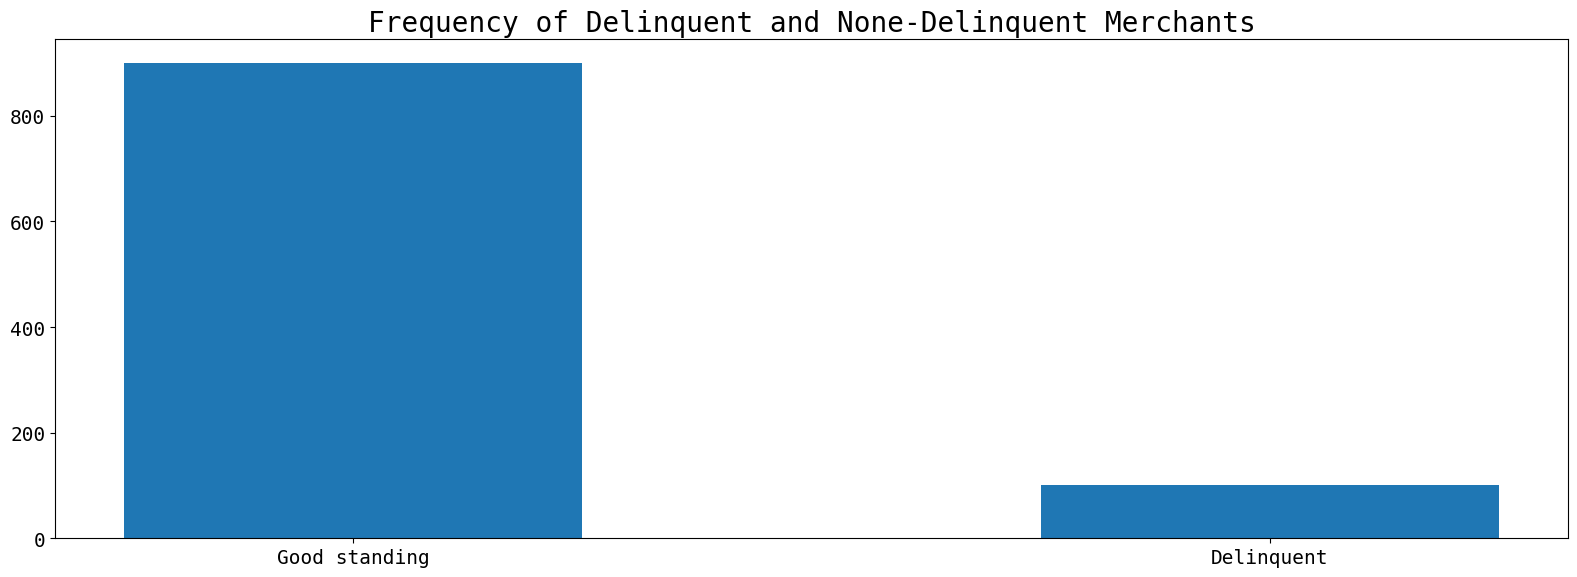

In [13]:
fig, ax = plt.subplots()
counts, bins = np.histogram(df.default_dum, bins=2)
bins = bins[[0,-1]]
myplt = ax.bar(bins, counts, width=0.5)
print(f'Default rate = {round(100*df.default_dum.mean(),2)}%')
ttl = ax.set_title('Frequency of Delinquent and None-Delinquent Merchants', fontsize=20)
xt = ax.set_xticks([0,1])
xtl = ax.set_xticklabels(['Good standing', 'Delinquent'])

In [14]:
xcols = df.columns[df.columns != 'default_dum']
xdf = df[xcols]
ydf = df['default_dum']
xdf.head()

,tenure,cont_per_month,contacts,delta_rev,int_rate
0,9.204294,0.599539,5.518338,-3.724717,0.565565
1,8.547449,0.691602,5.911436,3.980247,0.273561
2,7.987987,0.855838,6.836422,1.619792,0.369256
3,6.124808,1.086774,6.656283,-0.858296,0.486761
4,7.544128,0.798570,6.024518,7.881866,0.212416


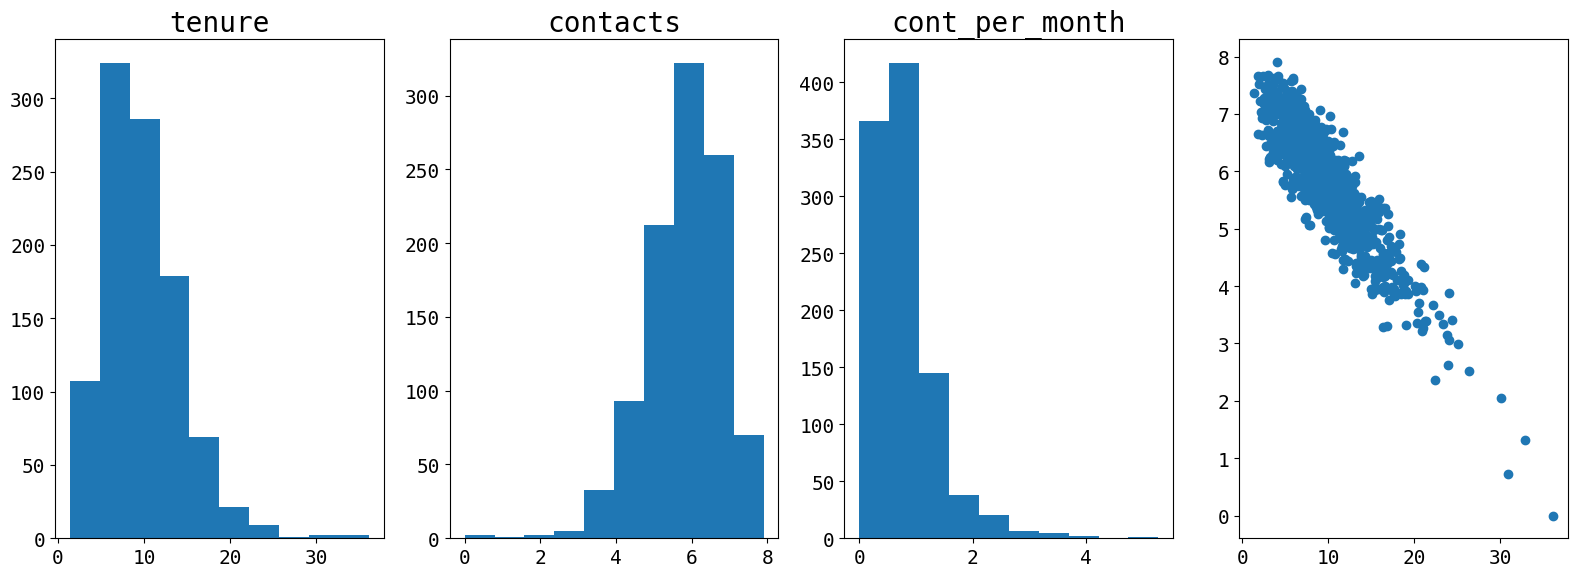

In [15]:
# by design: merchants with longer tenure contact less per month
fig, ax = plt.subplots(1,4)
feats_to_plot = ['tenure','contacts','cont_per_month','scatter']
for i, feat in enumerate(feats_to_plot):
  if feat != 'scatter':
    ax[i].hist(xdf[feat])
    ax[i].set_title(feat)
  else:
    ax[i].scatter(xdf['tenure'], xdf['contacts'])


In [16]:
def balance_data(ydf, xdf, sampling_method='over'):
    'Check repo'
    # find minority class: if mean < 0.5 -> minority class = 1
    min_class = 1*(ydf.mean() < 0.5)
    # get indices for classes
    loc_min = ydf == min_class
    min_ix = ydf[loc_min].index
    max_ix = ydf[loc_min==False].index
    n_min = len(min_ix)
    n_max = len(max_ix)
    if sampling_method == 'over':
        num_sml = n_max//n_min
        sml_ix = np.random.choice(min_ix, size = n_max, replace = True)
        sml_all = np.concatenate((sml_ix, max_ix),axis = 0)
    elif sampling_method == 'under':
        sml_ix = np.random.choice(max_ix, size = n_min, replace = True)
        sml_all = np.concatenate((sml_ix, min_ix),axis = 0)
    # ready to assemble everything
    y_new = ydf.loc[sml_all]
    x_new = xdf.loc[sml_all]
    return y_new, x_new

In [17]:
def plot_tpr_qtile(model, x_test, ax, num_qtile = 10):
  "Plot TPR by decile for classification models only"
  df_score = pd.DataFrame(model.predict_proba(x_test)[:,1], columns = ['score'], index = x_test.index)
  # get deciles
  deciles = pd.qcut(df_score.score, q = np.linspace(0,1,num_qtile+1))
  edges = deciles.apply(lambda x: x.left)
  decile_dic = {cat:i for i,cat in enumerate(np.sort(edges.unique()))}
  deciles_cats = edges.replace(decile_dic)
  df_score['deciles'] = deciles_cats
  df_score['y_test'] = y_test
  # plot
  tpr_per_decile = df_score.y_test.groupby(df_score.deciles).mean()
  ax = tpr_per_decile.plot(kind='bar', ax=ax)
  labs = [f'd{i}' for i in range(1,num_qtile+1)]
  ax.set_xticklabels(labs, rotation=0)
  ax.set_title(f'TPR per {num_qtile}-tiles')
  ax.set_xlabel(f'Score {num_qtile}-tiles')
  return tpr_per_decile

In [18]:
# split and then balance the training data
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, random_state=2127)
print('Before balancing')
print(f'Size of train/test= {y_train.shape[0]} / {y_test.shape[0]}')
print(f'% 1s in train/test= {100*y_train.mean(),round(100*y_test.mean())}')
print('-'*20)
print('After balancing')
y_train, x_train = balance_data(ydf = y_train, xdf = x_train, sampling_method='over')
print(f'Size of train/test= {y_train.shape[0]} / {y_test.shape[0]}')
print(f'% 1s in train/test= {100*y_train.mean(),round(100*y_test.mean())}')


Before balancing
Size of train/test= 800 / 200
% 1s in train/test= (9.625, 12)
--------------------
After balancing
Size of train/test= 1446 / 200
% 1s in train/test= (50.0, 12)


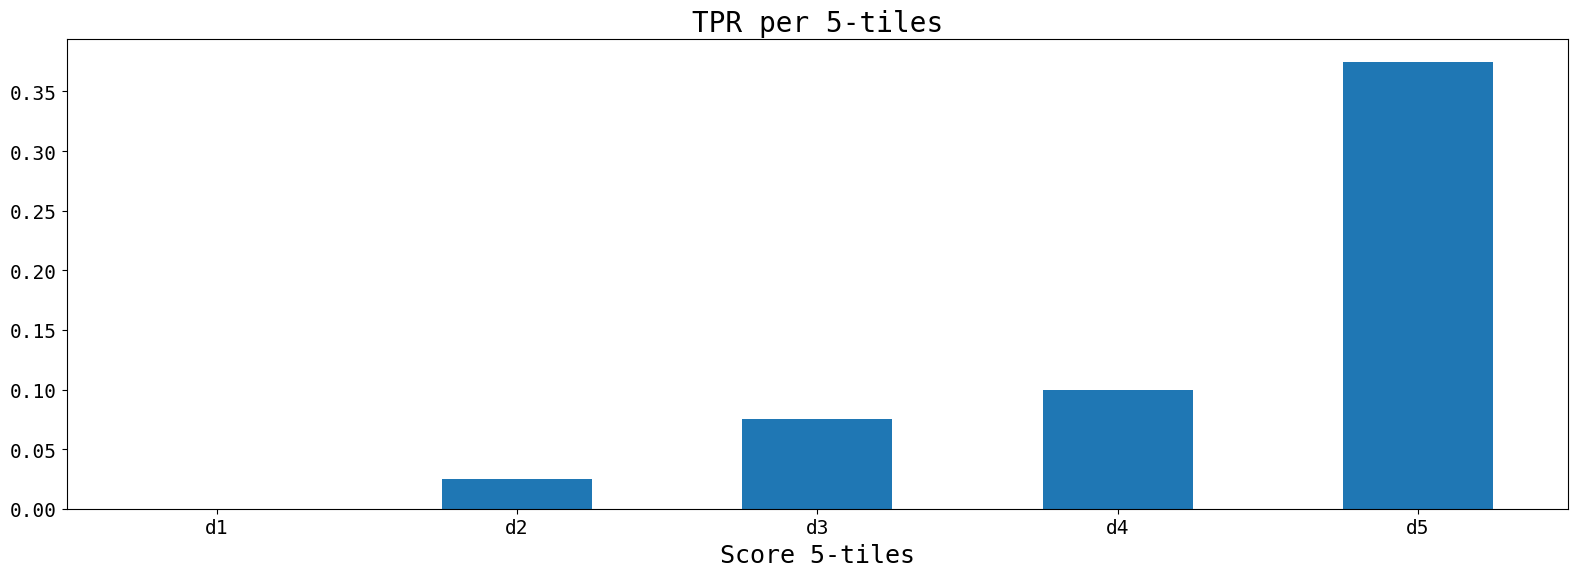

In [19]:
# let's start with a logistic regression
lreg = LogisticRegression(random_state=0).fit(x_train, y_train.values.flatten())
fig, ax = plt.subplots()
a = plot_tpr_qtile(lreg, x_test, ax, num_qtile = 5)

## Now Gradient Boosting Classifier

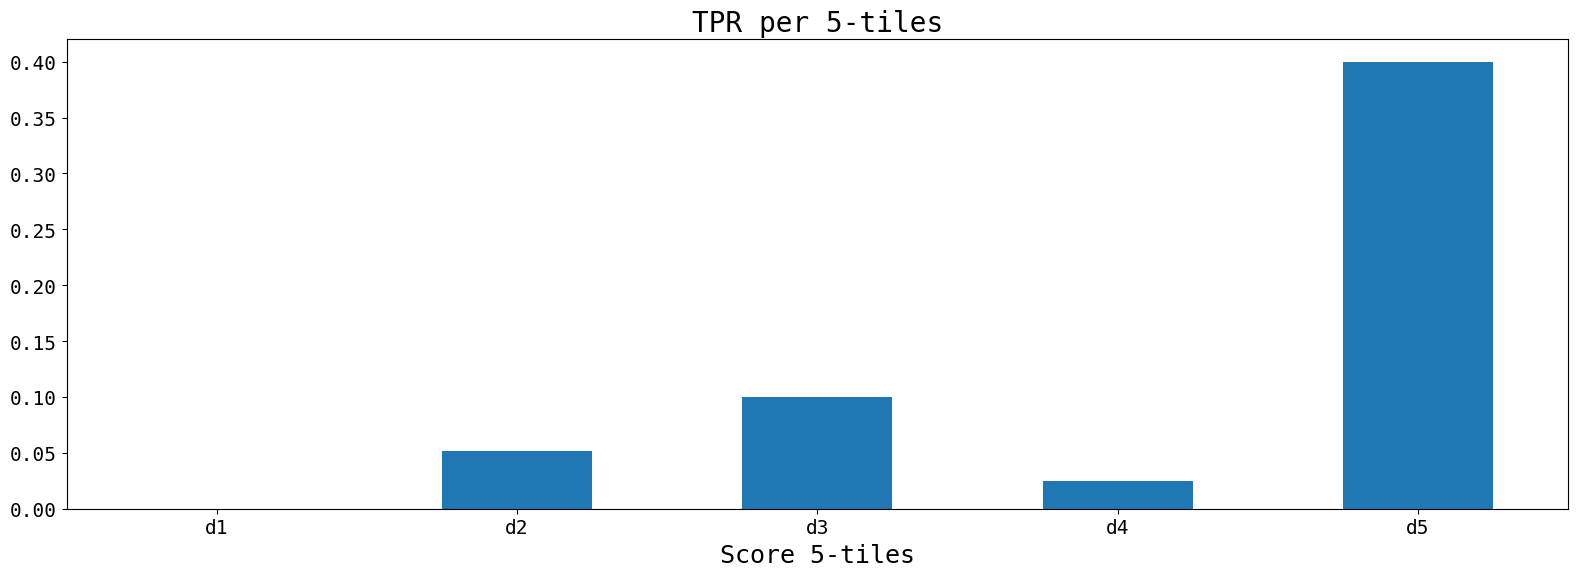

In [20]:
# Gradient boosting classifier
gbc = GradientBoostingClassifier(max_depth=2, random_state=10).fit(x_train, y_train.values.flatten())
fig, ax = plt.subplots()
a = plot_tpr_qtile(gbc, x_test, ax, num_qtile = 5)

### Compute heatmap

In [21]:
def standardize_df(df):
    df_std = (df - df.mean())/df.std()
    return df_std

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """
    See THP' repo
    """
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def plot_feature_heatmap(df, df_norm, ax, cmap, max_feats=20):
    """
    See THP' repo
    """
    df_norm = df_norm.loc[df_norm.index[:max_feats]]
    df = df.loc[df.index[:max_feats]]
    hm_plt = df.iloc[:max_feats,:]
    im = ax.imshow(df_norm, cmap = cmap)
    # Show all ticks and label them with the respective list entries
    y_len, x_len = df_norm.shape
    ax.set_xticks(np.arange(x_len))
    ax.set_yticks(np.arange(y_len))
    ax.set_xticklabels(df_norm.columns, rotation = 0)
    ax.set_yticklabels(df_norm.index)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(y_len):
        for j in range(x_len):
            text = ax.text(j, i, np.around(hm_plt.values[i, j], decimals = 2),
                                ha="center", va="center", color="k", fontsize = 12,
                                weight='bold')
    #ax.set_ylabel('Features')
    #ax.set_xlabel('Deciles')

    return ax


def create_feature_heatmap(model, ydf, xdf, ax, importance_order = 'permutation', is_regression = True,
                  cmap = cm.Blues, max_feats = 20):
    """
    See  repo
    """
    xdf_std = standardize_df(xdf)  # used for plotting only (see plot_heatmap())
    labs_dec = [f'd{i}' for i in range(1,11)]
    if is_regression:
        yhat = pd.DataFrame(model.predict(xdf), columns = ['yhat'])
        title_str = 'Yhat deciles'
    else:
        yhat = pd.DataFrame(model.predict_proba(xdf)[:,1], columns = ['yhat'])
        title_str = 'Score deciles'
    # compute deciles and average features by decile
    deciles = pd.qcut(x=yhat.yhat.values, q=10, labels=labs_dec, duplicates='drop')
    avg_df = xdf.groupby(deciles).mean().T
    avg_df_std = xdf_std.groupby(deciles).mean().T
    # NEW: get TPR by bucket
    tpr_df = pd.DataFrame(ydf.groupby(deciles).mean())
    list_tpr_labels = [f'{k} \n ({round(100*v,1)}%)' for   k,v in tpr_df.squeeze().to_dict().items()]
    # sort features and save in a DF, sorted
    if importance_order == 'impurity':
        try:
            feat_imp = model.feature_importances
        except AttributeError:
            print('WARNING! \nimpurity importance not available \nUsing order in xdf')
            feat_imp = range(len(xdf.columns))[::-1]
    elif importance_order == 'permutation':
        dict_impo = permutation_importance(model, xdf, ydf, n_repeats=10,random_state=2506)
        feat_imp = dict_impo['importances_mean']
    feat_df = pd.DataFrame(feat_imp, index = xdf.columns, columns = ['feature_imp'])
    feat_df = feat_df.sort_values(by = 'feature_imp', ascending = False)
    # sort using importances
    avg_df = avg_df.loc[feat_df.index]
    avg_df_std = avg_df_std.loc[feat_df.index]
    # ready to plot
    cmap = plt.get_cmap(cmap)
    new_cmap = truncate_colormap(cmap=cmap, minval=0.0, maxval=0.8, n=10)
    ax = plot_feature_heatmap(df=avg_df, df_norm=avg_df_std, ax=ax, cmap=new_cmap, max_feats=max_feats)
    ax.set_xlabel(title_str)
    ax.set_xticklabels(list_tpr_labels, fontsize=12)
    return ax

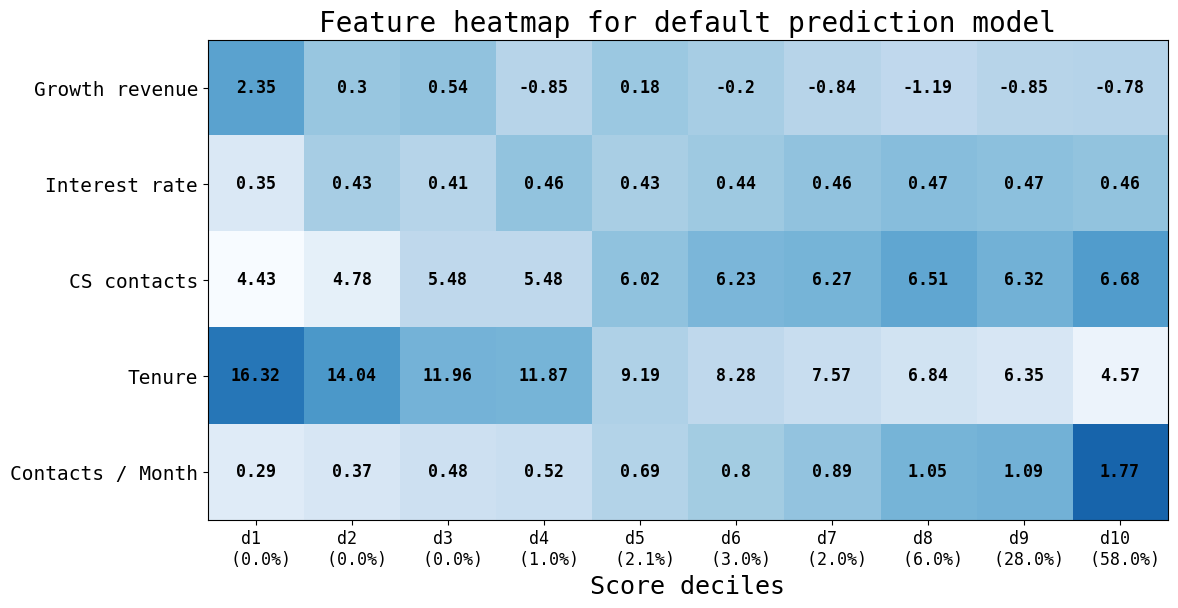

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
ax = create_feature_heatmap(model=gbc, ydf=ydf, xdf=xdf, ax=ax,
                            importance_order = 'permutation', is_regression = False)
ttl = ax.set_title('Feature heatmap for default prediction model')
# Get nice labels for your features!  Data scientists tend to forget this!
feat_labs = {'delta_rev':'Growth revenue',
             'int_rate': 'Interest rate',
             'contacts': 'CS contacts',
             'tenure': 'Tenure',
             'cont_per_month': 'Contacts / Month'}
curr_labs = [tt.get_text() for tt in ax.get_yticklabels()]
nice_labs = [feat_labs[lab] for lab in curr_labs]
yl = ax.set_yticklabels(nice_labs)




### Plot PDPs

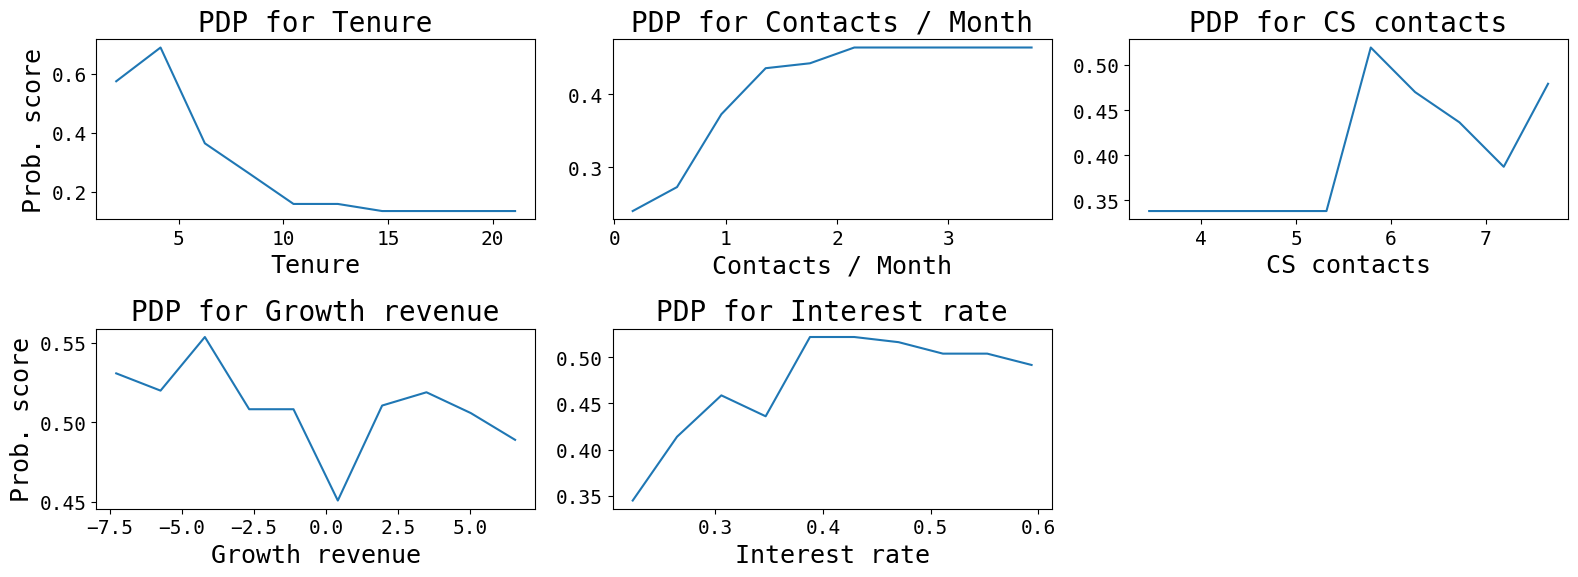

In [23]:

# plot PDPs
nfeats = xdf.columns.shape[0]
ncols = 3
nrow = 2
fig, ax = plt.subplots(nrow, ncols)
for i, feat in enumerate(xdf.columns):
  ix_i = i//ncols
  ix_j = i%ncols
  ax_ij = ax[ix_i, ix_j]
  pdp_i, ice = compute_pdp2(xdf=x_train, var_name = feat, model=gbc,pmin = 0.01, pmax=0.99, is_regression= False)
  pdp_i.plot(ax=ax_ij)
  ax_ij.set_title(f'PDP for {feat_labs[feat]}')
  ax_ij.get_legend().remove()
  ax_ij.set_xlabel(feat_labs[feat])
  if ix_j == 0:
    ax_ij.set_ylabel('Prob. score')
ax[-1,-1].set_visible(False)

In [24]:
uniti = xdf.head(1).T
uniti.rename(columns={0:'Observed'}, inplace=True)
G = 5
tenure_grid = np.linspace(xdf.tenure.min(),xdf.tenure.max(),G)
new_cols = [f'tenure = {round(g)}' for g in tenure_grid]
probs = [gbc.predict_proba(uniti[['Observed']].T)[0,1]]
for g in tenure_grid:
  new_col = f'tenure = {round(g)}'
  uniti[new_col] = uniti['Observed']
  uniti[new_col].loc['tenure'] = round(g)
  pi = gbc.predict_proba(uniti[[new_col]].T)[0,1]
  probs.append(pi)
  uniti[new_col].loc['predicted_prob'] = pi
uniti.rename(index={lab:feat_labs[lab]  for lab in uniti.index}, inplace=True)
uniti.loc['Predicted probability'] = probs
uniti.round(decimals=2)

,Observed,tenure = 1,tenure = 10,tenure = 19,tenure = 27,tenure = 36
Tenure,9.20,1.00,10.00,19.00,27.00,36.00
Contacts / Month,0.60,0.60,0.60,0.60,0.60,0.60
CS contacts,5.52,5.52,5.52,5.52,5.52,5.52
Growth revenue,-3.72,-3.72,-3.72,-3.72,-3.72,-3.72
Interest rate,0.57,0.57,0.57,0.57,0.57,0.57
Predicted probability,0.27,0.69,0.27,0.22,0.22,0.22


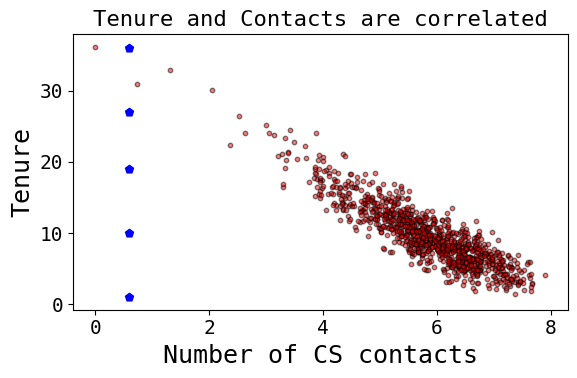

In [25]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(xdf['contacts'], xdf['tenure'], s=10, alpha=0.5, edgecolor='k', color='r')
ax.set_title('Tenure and Contacts are correlated', fontsize=16)
ax.set_ylabel('Tenure')
ax.set_xlabel('Number of CS contacts')
grid_tenure = [1,10,19,27,36]
obs_cont = [0.6]*len(grid_tenure)
ax.scatter(obs_cont, grid_tenure, color='b', marker='p')


In [26]:
tenure_test = 10
delta = 1
bool_tenure = np.logical_and(xdf.tenure >=tenure_test-delta, xdf.tenure <=tenure_test+delta)
avg_contact_bool = round(xdf[bool_tenure].contacts.mean(), 1)
print(f'Average contacts for those units with a tenure in the neighborhood of {tenure_test} = {avg_contact_bool}')

Average contacts for those units with a tenure in the neighborhood of 10 = 5.8


## Let' do some `local` calculations now

Suppose that we use this model to make offers to our SMBs, and decide that scores higher than `0.11` are too risky (see plot below), and someone who had their credit denied contacts CS trying to understand why.  Let's check what happened to that customer.

In [27]:
def compute_cumtpr_qtile(model, x_test, ax, num_qtile = 10):
  "Compute cumulative tpr"
  df_score = pd.DataFrame(model.predict_proba(x_test)[:,1], columns = ['score'],
                          index = x_test.index)
  # get deciles
  deciles = pd.qcut(df_score.score, q = np.linspace(0,1,num_qtile+1))
  edges = deciles.apply(lambda x: x.left)
  decile_dic = {cat:i for i,cat in enumerate(np.sort(edges.unique()))}
  deciles_cats = edges.replace(decile_dic)
  df_score['deciles'] = deciles_cats
  df_score['y_test'] = y_test
  grid_score = np.linspace(df_score.score.min(), df_score.score.max(),30)
  df_cumtpr = pd.DataFrame(index=grid_score, columns =['cum_tpr'])
  for g in grid_score[:-1]:
    bool_g = df_score.score>=g  #
    mean_g = df_score[bool_g].y_test.mean()
    df_cumtpr.cum_tpr.loc[g] = df_score[bool_g].y_test.mean()

  return df_cumtpr


Threshold score = 0.11 to get a minimum probability of repaying of 85.0%


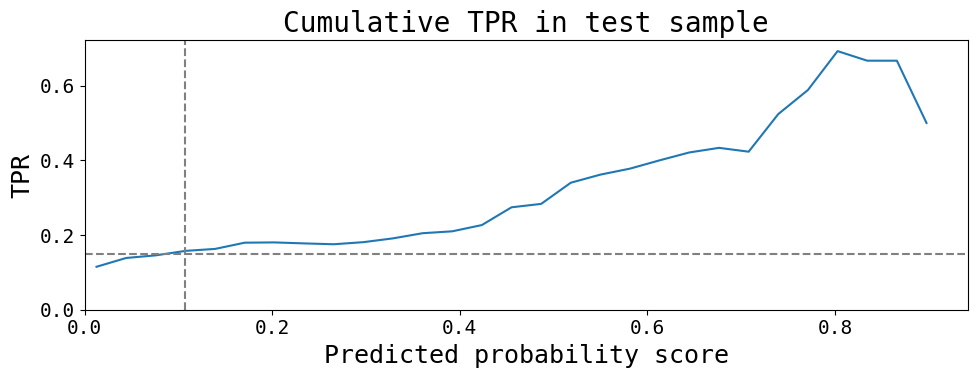

In [28]:
# find a thrshold default probability
cum_tpr = compute_cumtpr_qtile(model=gbc, x_test=x_test, ax=1, num_qtile = 10)
fig, ax = plt.subplots(figsize = (10,4))
#(1-cum_tpr).plot(ax=ax)  # we need the probability of repaying!
cum_tpr.plot(ax=ax)  # we need the probability of repaying!
ax.get_legend().remove()
ax.set_title('Cumulative TPR in test sample')
ax.set_xlabel('Predicted probability score')
ax.set_ylabel('TPR')
min_prob = 0.15
thresh = cum_tpr[cum_tpr.cum_tpr >= min_prob].index.min()
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.plot([thresh,thresh],[0,ymax], color='0.5', ls='--')
ax.plot([0,xmax],[min_prob,min_prob], color='0.5', ls='--')
lims = plt.axis([0, xmax, 0, ymax])
print(f'Threshold score = {round(thresh, 2)} to get a minimum probability of repaying of {100*(1-min_prob)}%')

In [29]:
seed = 2491
np.random.seed(seed)
y_test_pred = gbc.predict_proba(x_test)[:,1]
# you're denied if your score was higher than 0.11
rnd_unit_denied = np.random.choice(x_test[y_test_pred > 0.11].index, replace=False)
pos_unit_denied = np.arange(x_test.shape[0])[x_test.index == rnd_unit_denied][0]
print(f'Unit {rnd_unit_denied} contacts CS')
print(f'Check unit position = {x_test.index[pos_unit_denied]}')

Unit 470 contacts CS
Check unit position = 470


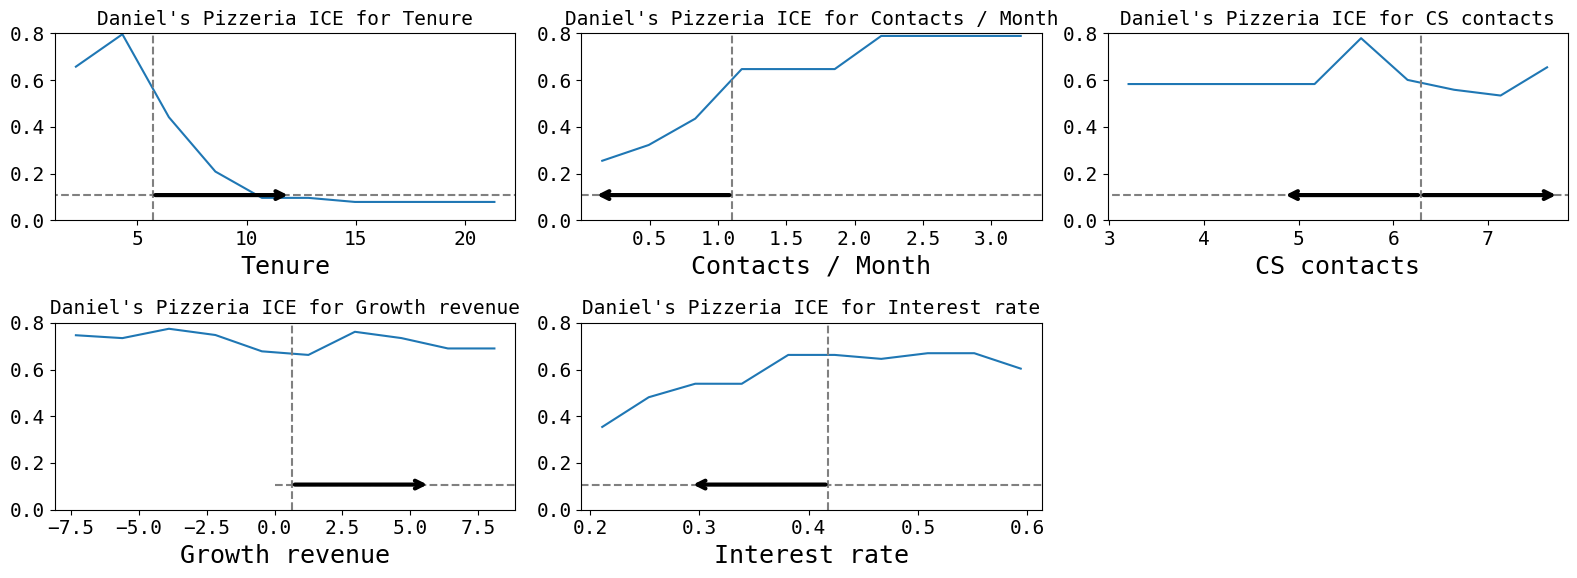

In [30]:
# we can use ICE here, that was already computed with PDPs (but we didn't save it)
ncols = 3
nrow = 2
fig, ax = plt.subplots(nrow, ncols)
dict_arrows = {'tenure': 'r', 'cont_per_month':'l', 'contacts':'lr', 'delta_rev':'r', 'int_rate':'l'}
for i, feat in enumerate(xdf.columns):
  ix_i = i//ncols
  ix_j = i%ncols
  ax_ij = ax[ix_i, ix_j]
  _, ice_i = compute_pdp2(xdf=x_test, var_name = feat, model=gbc,pmin = 0.01, pmax=0.99, is_regression= False)
  ice_i.loc[rnd_unit_denied].plot(ax=ax_ij)
  ax_ij.set_title(f"Daniel's Pizzeria ICE for {feat_labs[feat]}", fontsize=14)
  ax_ij.set_xlabel(feat_labs[feat])
  observed_feat = x_test[feat].loc[rnd_unit_denied]
  xmin, xmax = ax_ij.get_xlim()
  delta_max = 0.3*(xmax - xmin)
  ax_ij.plot([observed_feat,observed_feat],[0,0.8], color='0.5', ls='--')
  ax_ij.plot([0,xmax],[thresh,thresh], color='0.5', ls='--')
  ax_ij.axis([xmin,xmax,0,0.8])
  if dict_arrows[feat] == 'r':
    ax_ij.annotate(f"",xy=(observed_feat + delta_max, thresh), xytext=(observed_feat, thresh), verticalalignment='center',
              arrowprops=dict(arrowstyle="->", lw=3))
  elif dict_arrows[feat] == 'l':
    ax_ij.annotate(f"",xy=(observed_feat - delta_max, thresh), xytext=(observed_feat, thresh), verticalalignment='center',
              arrowprops=dict(arrowstyle="->", lw=3))
  else:
        ax_ij.annotate(f"",xy=(observed_feat + delta_max, thresh), xytext=(observed_feat, thresh), verticalalignment='center',
              arrowprops=dict(arrowstyle="->", lw=3))
        ax_ij.annotate(f"",xy=(observed_feat - delta_max, thresh), xytext=(observed_feat, thresh), verticalalignment='center',
              arrowprops=dict(arrowstyle="->", lw=3))

ax[-1,-1].set_visible(False)

## Shap values

In [31]:
# Calculate some final value and baseline (note that value isn't the same as in plot, but close enough :)
obs_proba = gbc.predict_proba(x_test)[pos_unit_denied,1]   #f(x_i) for given unit i
avg_proba_test = np.mean(gbc.predict_proba(x_test)[:,1])  # E(f(X))

print("{:<50} {:<20} {:<20}".format('Description','Probability','Log-odds'))
print("-"*90)
print("{:<50} {:<20} {:<20}".format('Selected unit', round(obs_proba,3), round(logit(obs_proba),3)))
print("{:<50} {:<20} {:<20}".format('Average probability in test', round(avg_proba_test,3), round(logit(avg_proba_test),3)))


Description                                        Probability          Log-odds            
------------------------------------------------------------------------------------------


NameError: name 'logit' is not defined

In [ ]:
# Let's check the feature values for the selected unit
x_test.loc[rnd_unit_denied]

In [ ]:
# waterfall plot
explainer = shap.TreeExplainer(gbc, x_test, model_output="probability")
shap_values = explainer(x_test)
shap.plots.waterfall(shap_values[pos_unit_denied])

In [ ]:
# let's explore the shap_values object for this unit
shap_values[pos_unit_denied]

In [ ]:
print(f'Percentage of SMBs that defaulted in test sample = {100*y_test.mean()}%')
comp_df = pd.DataFrame(x_test.loc[rnd_unit_denied].values, columns=["Dan's Pizzeria"], index = x_test.columns)
comp_df['Average'] = x_test.mean().values
comp_df['Diff'] = comp_df["Dan's Pizzeria"] - comp_df['Average']
comp_df['ratio'] = comp_df["Dan's Pizzeria"]/comp_df['Average']
comp_df['True DGP'] = ['+','+','0','-','-']
comp_df['Shapley'] = ['+','+','-','+','+']
comp_df.rename(index=feat_labs, inplace=True)
comp_df.round(decimals=2)

In [ ]:
# we can also get some global interpretability, averaging the contributions in the shap values across units
shap.plots.bar(shap_values)

In [ ]:
# plot individual contributions against actual values
# similar to PDPs
shap.plots.scatter(shap_values[:,['tenure', 'cont_per_month', 'contacts', 'delta_rev', 'int_rate']], color=shap_values)

In [ ]:
# force plot
shap.initjs()
shap.plots.force(shap_values)